In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import subprocess
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"
from scipy.stats import ttest_ind
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LinearRegression
from lifelines.statistics import logrank_test
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from glob import glob
from scipy import stats
from scipy.stats import pearsonr, levene
import os
import myvariant

In [2]:
EUR_path_interval = "%s/genetic_score/EUR_interval" % export_folder
EUR_path = "%s/genetic_score/EUR" % export_folder
#tag = "26_nov" one after NY, without age and sex covariates
tag = "20_dec_21"

In [3]:
export_folder = "/home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hippolyte_only/interval_processing"

In [4]:
def get_gene_names(to_query):
    mv = myvariant.MyVariantInfo()

    gene_names = {}
    a = mv.querymany(to_query,scopes='dbsnp.rsid', build="hg38",fetchall=False)

    for i in range(len(a)):
        q = a[i]["query"]
        try:
            gene = a[i]["cadd"]["gene"]["genename"]
        except:
            try:
                gene = a[i]["dbsnp"]["gene"]["symbol"]
            except:
                try:
                    gene = a[i]["wellderly"]["genename"]
                except:
                    try:
                        gene = a[i]["snpeff"]["ann"]["genename"]
                    except:
                        try:
                            gene = a[i]["snpeff"]["ann"][0]["genename"]
                        except:
                            if q == "rs111763415":
                                gene = "SUFU"
                            elif q == "rs568365616":
                                gene = "MOG"
                            else:
                                gene = "not found"
        if q in gene_names:
            gene_names[q].append(gene)
        else:
            gene_names[q] = [gene]
    
    for q in gene_names:
        gene_names[q] = list(set(gene_names[q]))
        gene_names[q] = ", ".join(gene_names[q])
    
    return gene_names

# GWAS of ADP without MPV

In [5]:
chr_group_files = glob("%s/%s/bolt_res_bgen_feb_ADP_pred_chr*" % (export_folder,tag))

In [6]:
bgs = []
for f in chr_group_files:
    df = pd.read_csv(f,sep="\t")
    assert df.isnull().sum(axis=0).sum() == 0
    bgs.append(df)
bg = pd.concat(bgs,axis=0).sort_values(["CHR","BP"])

In [7]:
bg.shape

(10013294, 16)

In [8]:
bg.tail()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,CHISQ_LINREG,P_LINREG,BETA,SE,CHISQ_BOLT_LMM_INF,P_BOLT_LMM_INF,CHISQ_BOLT_LMM,P_BOLT_LMM
810255,rs3896457,22,51237063,0,T,C,0.706491,1.0,0.152533,0.700,0.003014,0.007773,0.150335,0.700,0.175224,0.680
810256,rs200607599,22,51237364,0,A,G,0.988343,1.0,0.042470,0.840,0.002945,0.033024,0.007950,0.930,0.000878,0.980
810257,rs370652263,22,51237712,0,G,A,0.943215,1.0,6.615760,0.010,-0.038074,0.015395,6.116550,0.013,6.421100,0.011
810258,rs202228854,22,51240820,0,C,T,0.971713,1.0,4.123560,0.042,0.042942,0.021509,3.985790,0.046,4.249000,0.039
810259,rs575160859,22,51244237,0,C,T,0.989125,1.0,1.652870,0.200,-0.042165,0.034209,1.519200,0.220,1.583560,0.210


In [9]:
bg.loc[bg.CHR == 1]

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,CHISQ_LINREG,P_LINREG,BETA,SE,CHISQ_BOLT_LMM_INF,P_BOLT_LMM_INF,CHISQ_BOLT_LMM,P_BOLT_LMM
591379,rs367896724,1,10177,0,A,AC,0.623991,0.735090,0.267213,0.61,0.003642,0.008563,0.180860,0.67,0.208059,0.65
591380,rs145072688,1,10352,0,T,TA,0.622860,0.722254,0.759546,0.38,-0.007107,0.008604,0.682318,0.41,0.614900,0.43
591381,rs575272151,1,11008,0,C,G,0.915802,0.737639,0.654907,0.42,0.010514,0.014847,0.501494,0.48,0.647073,0.42
591382,rs544419019,1,11012,0,C,G,0.918340,0.730055,0.031515,0.86,0.000202,0.015148,0.000178,0.99,0.001427,0.97
591383,rs540538026,1,13110,0,G,A,0.942219,0.686493,0.007756,0.93,0.001711,0.018347,0.008700,0.93,0.002563,0.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1367704,rs541756783,1,249240099,0,T,TA,0.459485,1.000000,1.531720,0.22,-0.009172,0.007147,1.646970,0.20,1.595090,0.21
1367705,rs370070114,1,249240219,0,A,T,0.754115,1.000000,2.196830,0.14,-0.011711,0.008265,2.007480,0.16,1.816620,0.18
1367706,rs549505823,1,249240537,0,GGT,G,0.530149,1.000000,0.062346,0.80,-0.002580,0.007090,0.132442,0.72,0.119423,0.73
1367707,rs545682552,1,249240539,0,T,G,0.681124,1.000000,0.341434,0.56,0.004945,0.007622,0.420996,0.52,0.426978,0.51


In [10]:
gws = []
gw = pd.read_csv("%s/%s/bolt_res_feb_ADP_pred" % (export_folder,tag),sep="\t")
gw.P_BOLT_LMM = gw.P_BOLT_LMM.astype(float)
gws.append(gw)
gw = pd.concat(gws,axis=0,copy=False)
gw.rename(columns={"P_BOLT_LMM":"P","SNP":"ID","CHR":"#CHROM","BP":"POS"},inplace=True)

In [11]:
gw.loc[gw["#CHROM"] == 1]

,ID,#CHROM,POS,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,CHISQ_LINREG,P_LINREG,BETA,SE,CHISQ_BOLT_LMM_INF,P_BOLT_LMM_INF,CHISQ_BOLT_LMM,P
0,rs568149713,1,15777,0,A,G,0.991649,0.037321,0.057946,0.81,0.010224,0.039561,0.066790,0.80,0.047416,0.83
1,rs199745162,1,16949,0,A,C,0.986103,0.046968,0.110488,0.74,-0.014590,0.031151,0.219377,0.64,0.219455,0.64
2,rs533090414,1,18849,0,C,G,0.023377,0.051538,1.872690,0.17,0.030152,0.024132,1.561180,0.21,1.568770,0.21
3,rs2691277,1,52238,0,T,G,0.012176,0.049549,0.669428,0.41,-0.025087,0.032768,0.586122,0.44,0.673230,0.41
4,rs552304420,1,54712,0,T,C,0.993606,0.020649,1.073750,0.30,-0.042564,0.045096,0.890873,0.35,0.917142,0.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702606,rs541756783,1,249240099,0,T,TA,0.459485,0.000000,1.531720,0.22,-0.009172,0.007147,1.646970,0.20,1.595090,0.21
702607,rs370070114,1,249240219,0,A,T,0.754115,0.000000,2.196830,0.14,-0.011711,0.008265,2.007480,0.16,1.816620,0.18
702608,rs549505823,1,249240537,0,GGT,G,0.530149,0.000000,0.062346,0.80,-0.002580,0.007090,0.132442,0.72,0.119423,0.73
702609,rs545682552,1,249240539,0,T,G,0.681124,0.000000,0.341434,0.56,0.004945,0.007622,0.420996,0.52,0.426978,0.51


In [12]:
comp = pd.merge(gw[["ID","P","BETA"]], bg[["SNP","P_BOLT_LMM","BETA"]], left_on="ID", right_on="SNP",how="inner",suffixes=("","_bgen"))

In [13]:
comp.head()

,ID,P,BETA,SNP,P_BOLT_LMM,BETA_bgen
0,rs568149713,0.83,0.010224,rs568149713,0.65,0.017279
1,rs199745162,0.64,-0.014590,rs199745162,0.36,-0.025495
2,rs533090414,0.21,0.030152,rs533090414,0.21,0.028262
3,rs2691277,0.41,-0.025087,rs2691277,0.63,-0.013701
4,rs552304420,0.34,-0.042564,rs552304420,0.59,-0.023116


In [14]:
missing = bg.loc[~bg.SNP.isin(gw.ID.unique().tolist())]

In [15]:
missing["MBP"] = (missing["BP"] / int(1e6)).astype(int)

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
missing.loc[missing.P_BOLT_LMM < 5e-8].groupby(["CHR","MBP"]).P_BOLT_LMM.min()

CHR  MBP
1    156    9.000000e-09
     198    4.300000e-08
2    224    3.200000e-10
3    56     3.900000e-13
5    122    2.500000e-18
6    31     1.200000e-10
     147    4.600000e-08
9    99     2.600000e-09
10   121    3.300000e-10
12   122    1.000000e-35
16   81     1.600000e-20
17   3      2.100000e-08
19   55     1.800000e-17
Name: P_BOLT_LMM, dtype: float64

In [17]:
sub_comp = comp.sample(1000)

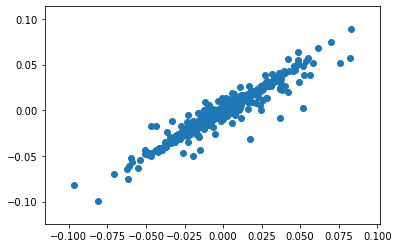

In [18]:
plt.scatter(sub_comp["BETA"],sub_comp["BETA_bgen"])

In [19]:
sub_comp = comp.loc[comp[["P","P_BOLT_LMM"]].min(axis=1) < 5e-8 ]

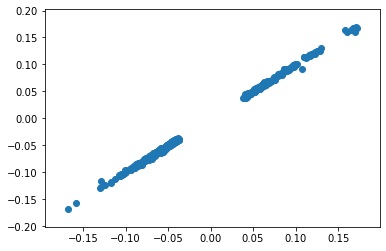

In [20]:
plt.scatter(sub_comp["BETA"],sub_comp["BETA_bgen"])

In [19]:
bg.rename(columns={"P_BOLT_LMM":"P","SNP":"ID","CHR":"#CHROM","BP":"POS"},inplace=True)

In [20]:
bg.head()

,ID,#CHROM,POS,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,CHISQ_LINREG,P_LINREG,BETA,SE,CHISQ_BOLT_LMM_INF,P_BOLT_LMM_INF,CHISQ_BOLT_LMM,P
591379,rs367896724,1,10177,0,A,AC,0.623991,0.735090,0.267213,0.61,0.003642,0.008563,0.180860,0.67,0.208059,0.65
591380,rs145072688,1,10352,0,T,TA,0.622860,0.722254,0.759546,0.38,-0.007107,0.008604,0.682318,0.41,0.614900,0.43
591381,rs575272151,1,11008,0,C,G,0.915802,0.737639,0.654907,0.42,0.010514,0.014847,0.501494,0.48,0.647073,0.42
591382,rs544419019,1,11012,0,C,G,0.918340,0.730055,0.031515,0.86,0.000202,0.015148,0.000178,0.99,0.001427,0.97
591383,rs540538026,1,13110,0,G,A,0.942219,0.686493,0.007756,0.93,0.001711,0.018347,0.008700,0.93,0.002563,0.96


In [21]:
df = bg

In [22]:
df.loc[df.ID == "rs1671152"]

,ID,#CHROM,POS,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,CHISQ_LINREG,P_LINREG,BETA,SE,CHISQ_BOLT_LMM_INF,P_BOLT_LMM_INF,CHISQ_BOLT_LMM,P
509662,rs1671152,19,55526345,0,T,G,0.161431,0.981968,80.907,2.400000e-19,-0.08621,0.009712,78.7965,6.900000e-19,80.9986,2.300000e-19


In [23]:
df.shape[0] // int(1e6)

10

In [24]:
df["MBP"] = df["POS"] // int(1e6)

In [25]:
df.loc[df.P < 5e-7].sort_values("P").groupby(["#CHROM","MBP"]).first()

ID        POS  GENPOS ALLELE1                    ALLELE0  \
#CHROM MBP                                                                      
1      156   rs12566888  156869047       0       G                          T   
       157    rs2068299  157048876       0       T                          C   
       161       rs3557  161188893       0       T                          G   
       198    rs6667939  198994619       0       C                          T   
       199    rs1434282  199010721       0       C                          T   
       207   rs34101855  207281706       0       A                         AG   
       247   rs41315846  247712303       0       T                          C   
2      224   rs13412535  224874874       0       G                          A   
       241   rs78909033  241510903       0       G                          A   
3      56     rs1354034   56849749       0       T                          C   
       124   rs13067286  124340093       0       G                          A   
       139   rs34391058  139377728       0      TC                          T   
4      185   rs56142867  185930590       0       A                          G   
5      50   rs187185117   50717778       0       A                          G   
       72     rs7713398   72252475       0       A                          G   
       122     rs922140  122088890       0       A                          G   
6      31     rs3819288   31322694       0       T                          C   
       33    rs62407572   33561303       0       A                          C   
       137   rs12191772  137259725       0       G                          A   
       139  rs568737404  139853729       0      AT                          A   
       147  rs150169446  147658350       0       C  CACACACACACACACACACACACAA   
8      106    rs6993770  106581528       0       A                          T   
9      99    rs55665228   99234329       0       C                          T   
       113   rs61751937  113312231       0       G                          C   
10     121   rs10886430  121010256       0       A                          G   
11     10     rs7123827   10711817       0       A                          C   
12     40   rs188573700   40567504       0       T                          C   
       122   rs11553699  122216910       0       A                          G   
14     70    rs61978213   70653758       0       G                          A   
15     65    rs59001897   65160392       0       T                          A   
16     9      rs8057254    9052989       0       T                          A   
       81    rs12445050   81870969       0       C                          T   
17     3     rs11078475    3819002       0       T                          C   
19     38    rs35496032   38817628       0       G                          A   
       55     rs1654425   55538980       0       T                          C   

              A1FREQ      INFO  CHISQ_LINREG      P_LINREG      BETA  \
#CHROM MBP                                                             
1      156  0.908592  0.990063      103.2140  3.000000e-24  0.124800   
       157  0.956476  0.927847       44.6612  2.300000e-11  0.119259   
       161  0.909377  0.957902       27.2545  1.800000e-07  0.065279   
       198  0.280871  0.949222       69.6417  7.100000e-17  0.067636   
       199  0.271769  0.954855       72.5839  1.600000e-17  0.069544   
       207  0.878615  0.978500       24.8871  6.100000e-07  0.054702   
       247  0.527832  0.947171       45.1039  1.900000e-11  0.049249   
2      224  0.759700  0.841967       40.8038  1.700000e-10  0.057557   
       241  0.862833  0.977122       43.2816  4.700000e-11  0.069758   
3      56   0.401179  0.988307      101.1460  8.500000e-24  0.074894   
       124  0.517422  0.997254       45.7772  1.300000e-11 -0.047616   
       139  0.507025  0.958145       27.6083  1.500000e-07 -0.037756   
4      185  0.7

In [26]:
# GRK5
df.loc[df.ID == "rs10886430"]

,ID,#CHROM,POS,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,CHISQ_LINREG,P_LINREG,BETA,SE,CHISQ_BOLT_LMM_INF,P_BOLT_LMM_INF,CHISQ_BOLT_LMM,P,MBP
1158148,rs10886430,10,121010256,0,A,G,0.861058,0.889466,40.5053,2.000000e-10,-0.068886,0.010871,40.1561,2.300000e-10,39.5116,3.300000e-10,121


In [27]:
recap_noMPV = df.loc[(df.P < 5e-8) & (df.ID != ".")].groupby(["#CHROM","MBP"]).first()

In [28]:
gw_ = df.copy()

In [29]:
UKBB_SNPS = []
for chrom in tqdm(range(1,23)):
    with open("%s/UKBB_SNPS_CHR%d.snplist" % (export_folder, chrom)) as f:
        UKBB_SNPS += [c[:-1] for c in f.readlines()]

print(len(UKBB_SNPS))
print(UKBB_SNPS[:10])

100%|██████████| 22/22 [01:23<00:00,  3.79s/it]

93095623
['rs367896724', 'rs540431307', 'rs201106462', 'rs548419688', 'rs568405545', 'rs534229142', 'rs537182016', 'rs572818783', 'rs538322974', '1:10616_CCGCCGTTGCAAAGGCGCGCCG_C']


In [30]:
gw_.loc[gw_.ID == "rs1671152"]

,ID,#CHROM,POS,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,CHISQ_LINREG,P_LINREG,BETA,SE,CHISQ_BOLT_LMM_INF,P_BOLT_LMM_INF,CHISQ_BOLT_LMM,P,MBP
509662,rs1671152,19,55526345,0,T,G,0.161431,0.981968,80.907,2.400000e-19,-0.08621,0.009712,78.7965,6.900000e-19,80.9986,2.300000e-19,55


In [31]:
gw_["IN_UKBB"] = gw_.ID.isin(UKBB_SNPS)
print(gw_["IN_UKBB"].mean())

0.9127451965357254


In [32]:
gw_["G_POS"] = 0
offset = 0
for chrom in tqdm(range(1,23)):
    chrom_cond = gw_["#CHROM"] == chrom
    gw_.loc[chrom_cond,"G_POS"] = gw_.loc[chrom_cond,"POS"] + offset
    offset = int(1e6) + gw_.loc[chrom_cond,"G_POS"].max()

100%|██████████| 22/22 [00:02<00:00,  9.66it/s]


# Causal analysis

In [40]:
pheno_cols = ["ADP_pred"]

In [41]:
phenotypes = pd.read_csv("%s/%s/hippo_ADP.csv" % (export_folder,tag), sep="\t")
cov = pd.read_csv("%s/%s/covariates_PCs_noMPV.csv" % (export_folder,tag), sep="\t")

In [42]:
phenotypes.head()

,FID,IID,ADP_pred
0,110005883349,110005883349,0.463093
1,110005883350,110005883350,2.932246
2,110003971725,110003971725,-0.201186
3,110003971720,110003971720,0.760903
4,110003971745,110003971745,0.574842


In [43]:
cov.head()

,FID,IID,AGE,SEX,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,F14,F16,M08,M10,M12
0,110005883349,110005883349,20.8,1,-0.001934,-0.000559,-0.003877,-0.002396,0.004759,0.009209,-0.007094,0.005961,-0.002420,0,0,1,0,0
1,110005883350,110005883350,28.5,1,0.005680,-0.003885,0.006915,-0.005141,-0.007857,-0.005673,0.002623,0.004581,-0.002501,0,0,0,1,0
2,110003971725,110003971725,56.4,2,0.006316,-0.008532,-0.002536,0.005346,0.003799,-0.004373,-0.001642,-0.002100,0.001090,1,0,0,0,0
3,110003971720,110003971720,61.5,2,0.000077,0.005795,-0.001567,0.003430,-0.008434,0.002795,0.001299,-0.007729,0.002039,1,0,0,0,0
4,110003971745,110003971745,34.4,1,-0.006810,-0.003914,0.003027,-0.006723,-0.000179,-0.005756,-0.000391,-0.005852,0.002590,0,0,0,1,0


In [44]:
phenotypes["ID"] = phenotypes["FID"].astype(str) + "_" + phenotypes["IID"].astype(str)
phenotypes = phenotypes.set_index("ID")[pheno_cols]

cov["ID"] = cov["FID"].astype(str) + "_" + cov["IID"].astype(str)
covar_cols = [c for c in list(cov.columns) if c not in ["ID","IID","FID"]]
cov = cov.set_index("ID")[covar_cols]

X = pd.merge(cov,phenotypes,left_index=True,right_index=True)

In [45]:
X.head()

,AGE,SEX,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,F14,F16,M08,M10,M12,ADP_pred
ID,,,,,,,,,,,,,,,,,
110005883349_110005883349,20.8,1,-0.001934,-0.000559,-0.003877,-0.002396,0.004759,0.009209,-0.007094,0.005961,-0.002420,0,0,1,0,0,0.463093
110005883350_110005883350,28.5,1,0.005680,-0.003885,0.006915,-0.005141,-0.007857,-0.005673,0.002623,0.004581,-0.002501,0,0,0,1,0,2.932246
110003971725_110003971725,56.4,2,0.006316,-0.008532,-0.002536,0.005346,0.003799,-0.004373,-0.001642,-0.002100,0.001090,1,0,0,0,0,-0.201186
110003971720_110003971720,61.5,2,0.000077,0.005795,-0.001567,0.003430,-0.008434,0.002795,0.001299,-0.007729,0.002039,1,0,0,0,0,0.760903
110003971745_110003971745,34.4,1,-0.006810,-0.003914,0.003027,-0.006723,-0.000179,-0.005756,-0.000391,-0.005852,0.002590,0,0,0,1,0,0.574842


In [46]:
from sklearn.metrics import log_loss
from scipy.stats import chi2
import math

In [47]:
def get_p_value(source,target):
    lm = LinearRegression().fit(source,target)
    return pearsonr(target,lm.predict(source))[1]

def calcLogLikelihood(guess, true, n):
    error = true-guess
    sigma = np.std(true)
    #f = ((1.0/(2.0*math.pi*sigma*sigma))**(n/2))* \
    #    np.exp(-1*((np.dot(error.T,error))/(2*sigma*sigma)))
    
    f = -(n/2)*np.log(2*math.pi*(sigma**2))
    f -= (np.dot(error.T,error))/(2*sigma*sigma)
    
    return f

def compare_p_values(X,model,augmented_model,Y):
    lm1 = LinearRegression()
    lm1.fit(X[model],Y)
    lm2 = LinearRegression()
    lm2.fit(X[augmented_model],Y)
    
    fit_1 = lm1.predict(X[model])
    fit_2 = lm2.predict(X[augmented_model])
    
    # Log_loss is minus log-likelihood
    LL_1 = calcLogLikelihood(fit_1,Y,Y.shape[0])
    LL_2 = calcLogLikelihood(fit_2,Y,Y.shape[0])
    Delta_LL = LL_2 - LL_1 # Delta_LL is positive
    LR = 2*Delta_LL
    p_val = chi2.sf(LR, 1)
    #print(p_val)
    
    #print("LL : %.2f" % p_val)
    
    # Checked that it yields the same result !
    
    #residuals = Y-fit_1
    #lm3 = LinearRegression()
    #lm3.fit(X[augmented_model],residuals)
    #fit3 = lm3.predict(X[augmented_model])
    #p_val2 = pearsonr(fit3,residuals)[1]
    #
    #print("Pearson : %.2f" % p_val2)
    
    #residuals_1 = Y-fit_1
    #residuals_2 = Y-fit_2
    
    #p_val = levene(residuals_1,residuals_2,center="mean")[1]
    #p_val = levene(fit_1,fit_2,center="mean")[1]
    
    return p_val

In [48]:
gw_ = gw_.rename(columns={"ID":"SNP","#CHROM":"CHR","POS":"BP"})

In [49]:
gw_["pheno"] = "ADP_pred"

In [50]:
# POS devrait être la position globale sur le génome

## Run

In [51]:
covar_cols = ['AGE',
 'SEX',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5',
 'PC6',
 'PC7',
 'PC8',
 'PC9',
 'F14','F16','M08','M10','M12']

In [52]:
X_ = X

In [53]:
X.shape

(23633, 17)

In [54]:
X_.shape

(23633, 17)

In [55]:
max_distance = 5e6 # from Dragana's
significant_SNPs = {}
P_threshold = 1e-8
genotypes = {}
for c in ["ADP_pred"]:
    print("Starting causal SNPs extraction")
    print(c)
    significant_SNPs[c] = []
    d = gw_.loc[gw_.pheno == c]
    hits = d.loc[(d.P < P_threshold) & (d.IN_UKBB)].copy()
    hits["region"] = AgglomerativeClustering(n_clusters=None,distance_threshold=max_distance,linkage="single")\
                        .fit(np.reshape(hits.G_POS.values,(-1,1)))\
                        .labels_
    for region, h in hits.groupby("region"):
        print("Region %d / %d" % (region,hits.region.nunique()))
        #if h.shape[0] == 1:
        #    significant_SNPs[c].append(h["SNP"].iloc[0])
        #    continue
        
        # Write the list of SNPS to a file
        SNP_list_file = "%s/conditional_analysis/significant_snps_%s_%s.txt" % (export_folder,c, tag)
        with open(SNP_list_file,"w") as file:
            for s in h.SNP.tolist():
                file.write("%s\n" % s)
        
        # Extract the table
        ch = int(h.CHR.iloc[0])
        gen_path = "%s/conditional_analysis/genotypes_region_%d_%s_CHR_%d" % (export_folder, region, c, ch)
        command = "/home/hv270/plink"
        command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d" % ch
        command += " --extract %s" % SNP_list_file
        command += " --keep %s" % EUR_path_interval
        command += " --mac 50"
        command += " --recode A-transpose --out %s" % gen_path
        p = subprocess.Popen(command,shell=True)
        p.wait()
        print("Done exporting genotypes")
        df = pd.read_csv("%s.traw" % (gen_path),sep="\t")
        df = df.set_index("SNP")
        ID_cols = list(set([c for c in df.columns if c not in ["CHR","(C)M","POS","COUNTED","ALT"]]))
        df = df[ID_cols].T
        df = df.loc[:, ~df.columns.duplicated()]
        var_cols = list(set(list(df.columns)))
        
        for var in var_cols:
            is_null = df[var].isnull()
            df.loc[is_null,var] = df.loc[~is_null,var].mean()
        
        G_X = pd.merge(df,X_.copy(),left_index=True,right_index=True)
        
        G = G_X[var_cols]
        G = G.loc[:,~G.columns.duplicated()]
        C = G_X[covar_cols]
        Y = G_X[[c]]
        
        # Adjust phenotype by covariates
        lm_covars = LinearRegression().fit(C,Y)
        Y[c] = Y[c] - lm_covars.predict(C)[:,0]
        
        univariable_p_values = [pearsonr(G[snp],Y[c])[1] for snp in G.columns]
        G = G[h.sort_values("P").SNP.tolist()]
        
        model = [G.columns[0]]
        vars_not_in_model = lambda : [v for v in G.columns if v not in model]
        
        while True and (len(vars_not_in_model()) > 0):
            # Augment the model
            print("%d vars not in model" % len(vars_not_in_model()))
            addition_p_values = pd.Series(index=vars_not_in_model(),dtype=float)
            for s in addition_p_values.index:
                #print("Trying to add %s" % s)
                LD = False
                for m in model:
                    R_2 = pearsonr(G[m],G[s])[0]**2
                    if R_2 >= 0.9:
                        addition_p_values.loc[s] = 1.
                        LD = True
                if LD: continue
                augmented_model = model + [s]
                addition_p_values.loc[s] = compare_p_values(G,model,augmented_model,Y[c])
            if addition_p_values.min() >= P_threshold:
                print("Nothing to add, keep %s" % (model))
                break
            else:
                to_add = addition_p_values.sort_values().index[0]
                print("Adding %s" % to_add)
                model.append(to_add)
            
            # Reduce the model
            reduce = True
            while reduce:
                reduce = False
                removal_p_values = pd.Series(index=model,dtype=float)
                for s in removal_p_values.index:
                    #print("Trying to remove %s" % s)
                    reduced_model = [m for m in model if m != s]
                    removal_p_values.loc[s] = compare_p_values(G,reduced_model,model,Y[c])
                if removal_p_values.max() <= P_threshold:
                    pass
                    # Go to augment
                else:
                    to_remove = removal_p_values.sort_values().index[-1]
                    print("Removing %s" % to_remove)
                    model = [m for m in model if m != to_remove]
                    reduce = True if len(model) >= 2 else False
                    # Go to reduce
        
        significant_SNPs[c] += model
        
        print("Done causal variant extraction. Kept %d out of %d" % (len(model),len(var_cols)))
        print("Hit : ")
        print(h.loc[h.SNP.isin(model),["CHR","BP","SNP","P","BETA"]])
        
        genotypes[(c, region)] = G[model]
    

Starting causal SNPs extraction
ADP_pred
Region 0 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


35 vars not in model
Nothing to add, keep ['rs1434282']
Done causal variant extraction. Kept 1 out of 36
Hit : 
         CHR         BP        SNP             P      BETA
1177872    1  199010721  rs1434282  8.300000e-18  0.069544
Region 1 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


12 vars not in model
Nothing to add, keep ['rs55665228']
Done causal variant extraction. Kept 1 out of 13
Hit : 
         CHR        BP         SNP             P      BETA
1112366    9  99234329  rs55665228  6.800000e-11  0.062166
Region 2 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


42 vars not in model
Nothing to add, keep ['rs11553699']
Done causal variant extraction. Kept 1 out of 43
Hit : 
         CHR         BP         SNP             P     BETA
1696568   12  122216910  rs11553699  1.000000e-35 -0.13446
Region 3 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


97 vars not in model
Nothing to add, keep ['rs12566888']
Done causal variant extraction. Kept 1 out of 98
Hit : 
         CHR         BP         SNP             P    BETA
1028156    1  156869047  rs12566888  1.200000e-24  0.1248
Region 4 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


48 vars not in model
Nothing to add, keep ['rs3819288']
Done causal variant extraction. Kept 1 out of 49
Hit : 
         CHR        BP        SNP             P      BETA
1890319    6  31322694  rs3819288  7.100000e-13  0.083528
Region 5 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


27 vars not in model
Adding rs76445378
26 vars not in model
Nothing to add, keep ['rs13067286', 'rs76445378']
Done causal variant extraction. Kept 2 out of 28
Hit : 
         CHR         BP         SNP             P      BETA
1164678    3  124340093  rs13067286  1.900000e-11 -0.047616
1164901    3  124366890  rs76445378  2.800000e-09  0.167710
Region 6 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1 vars not in model
Nothing to add, keep ['rs61751937']
Done causal variant extraction. Kept 1 out of 2
Hit : 
         CHR         BP         SNP             P      BETA
1165626    9  113312231  rs61751937  5.000000e-16 -0.169112
Region 7 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2 vars not in model
Nothing to add, keep ['rs41315846']
Done causal variant extraction. Kept 1 out of 3
Hit : 
         CHR         BP         SNP             P      BETA
1361316    1  247712303  rs41315846  9.200000e-12  0.049249
Region 8 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1 vars not in model
Nothing to add, keep ['rs13412535']
Done causal variant extraction. Kept 1 out of 2
Hit : 
        CHR         BP         SNP             P      BETA
760776    2  224874874  rs13412535  3.200000e-10  0.057557
Region 9 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


80 vars not in model
Nothing to add, keep ['rs12445050']
Done causal variant extraction. Kept 1 out of 81
Hit : 
        CHR        BP         SNP             P      BETA
808566   16  81870969  rs12445050  3.100000e-25 -0.107511
Region 10 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


25 vars not in model
Nothing to add, keep ['rs1354034']
Done causal variant extraction. Kept 1 out of 26
Hit : 
        CHR        BP        SNP             P      BETA
937346    3  56849749  rs1354034  6.200000e-25  0.074894
Region 11 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


117 vars not in model
Nothing to add, keep ['rs1654425']
Done causal variant extraction. Kept 1 out of 118
Hit : 
        CHR        BP        SNP             P      BETA
509747   19  55538980  rs1654425  1.200000e-22 -0.091918
Region 12 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2 vars not in model
Nothing to add, keep ['rs7123827']
Done causal variant extraction. Kept 1 out of 3
Hit : 
       CHR        BP        SNP             P      BETA
50331   11  10711817  rs7123827  8.800000e-10 -0.043878
Region 13 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3 vars not in model
Nothing to add, keep ['rs8057254']
Done causal variant extraction. Kept 1 out of 4
Hit : 
        CHR       BP        SNP             P      BETA
593700   16  9052989  rs8057254  1.700000e-09 -0.055509
Region 14 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2 vars not in model
Nothing to add, keep ['rs59001897']
Done causal variant extraction. Kept 1 out of 3
Hit : 
         CHR        BP         SNP             P      BETA
1011928   15  65160392  rs59001897  3.600000e-09 -0.055161
Region 15 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
        CHR         BP         SNP             P      BETA
828111    2  241510903  rs78909033  2.000000e-11  0.069758
Region 16 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Done causal variant extraction. Kept 1 out of 1
Hit : 
         CHR         BP         SNP             P      BETA
1158148   10  121010256  rs10886430  3.300000e-10 -0.068886
Region 17 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1 vars not in model
Nothing to add, keep ['rs61978213']
Done causal variant extraction. Kept 1 out of 2
Hit : 
         CHR        BP         SNP             P      BETA
1335209   14  70653758  rs61978213  1.300000e-12 -0.124011
Region 18 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


8 vars not in model
Nothing to add, keep ['rs11078475']
Done causal variant extraction. Kept 1 out of 9
Hit : 
         CHR       BP         SNP             P      BETA
1817774   17  3819002  rs11078475  1.700000e-10 -0.045222
Region 19 / 20
Done exporting genotypes


/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


517 vars not in model
Nothing to add, keep ['rs922140']
Done causal variant extraction. Kept 1 out of 518
Hit : 
         CHR         BP       SNP             P      BETA
1658110    5  122088890  rs922140  6.600000e-21 -0.068151


In [56]:
len(significant_SNPs["ADP_pred"])

21

## Gather

In [57]:
all_significant_SNPs = []
for c in significant_SNPs:
    all_significant_SNPs += significant_SNPs[c]
all_significant_SNPs = list(set(all_significant_SNPs))
recap = pd.DataFrame(index=all_significant_SNPs)
for c in pheno_cols:
    recap["causal_%s" % c] = recap.index.isin(significant_SNPs[c])


In [58]:
gw_.head()

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,CHISQ_LINREG,P_LINREG,BETA,SE,CHISQ_BOLT_LMM_INF,P_BOLT_LMM_INF,CHISQ_BOLT_LMM,P,MBP,IN_UKBB,G_POS,pheno
591379,rs367896724,1,10177,0,A,AC,0.623991,0.735090,0.267213,0.61,0.003642,0.008563,0.180860,0.67,0.208059,0.65,0,True,10177,ADP_pred
591380,rs145072688,1,10352,0,T,TA,0.622860,0.722254,0.759546,0.38,-0.007107,0.008604,0.682318,0.41,0.614900,0.43,0,False,10352,ADP_pred
591381,rs575272151,1,11008,0,C,G,0.915802,0.737639,0.654907,0.42,0.010514,0.014847,0.501494,0.48,0.647073,0.42,0,True,11008,ADP_pred
591382,rs544419019,1,11012,0,C,G,0.918340,0.730055,0.031515,0.86,0.000202,0.015148,0.000178,0.99,0.001427,0.97,0,True,11012,ADP_pred
591383,rs540538026,1,13110,0,G,A,0.942219,0.686493,0.007756,0.93,0.001711,0.018347,0.008700,0.93,0.002563,0.96,0,True,13110,ADP_pred


In [59]:
for c in pheno_cols:
    recap = pd.merge(recap,
                     gw_.loc[gw_.pheno == c,["SNP","BETA","P"]].set_index("SNP").rename(columns={"BETA":"BETA_%s" % c,
                                                                                               "P":"P_%s" % c}),
                     left_index=True,right_index=True)

In [60]:
recap = pd.merge(recap,gw_.loc[(gw_.pheno == pheno_cols[0]) & (gw_.P < 5e-8),["SNP","CHR","BP"]].set_index("SNP"),left_index=True,right_index=True)

## Export

In [61]:
pheno_cols

['ADP_pred']

In [62]:
snp_path = "%s/conditional_analysis/causal_SNPs_BOLT_%s_%s.txt" % (export_folder,tag,"ADP_pred")

In [63]:
with open(snp_path,"w") as f:
    for snp in significant_SNPs[c]:
        f.write("%s\n" % snp)

In [64]:
significant_SNPs["ADP_pred"]

['rs1434282',
 'rs55665228',
 'rs11553699',
 'rs12566888',
 'rs3819288',
 'rs13067286',
 'rs76445378',
 'rs61751937',
 'rs41315846',
 'rs13412535',
 'rs12445050',
 'rs1354034',
 'rs1654425',
 'rs7123827',
 'rs8057254',
 'rs59001897',
 'rs78909033',
 'rs10886430',
 'rs61978213',
 'rs11078475',
 'rs922140']

In [65]:
gene_names = get_gene_names(significant_SNPs["ADP_pred"])
gene_names_df = pd.DataFrame.from_dict(gene_names,orient="index").rename(columns={0:"GENE"})

querying 1-21...done.
Finished.
9 input query terms found dup hits:
	[('rs61751937', 2), ('rs41315846', 2), ('rs13412535', 2), ('rs1654425', 3), ('rs7123827', 2), ('rs80
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [66]:
gene_names_df

,GENE
rs1434282,LINC01221
rs55665228,HABP4
rs11553699,TMEM120B
rs12566888,PEAR1
rs3819288,MIR6891
rs13067286,KALRN
rs76445378,KALRN
rs61751937,SVEP1
rs41315846,GCSAML
rs13412535,SERPINE2


In [67]:
good = gw_.loc[(gw_.pheno == "ADP_pred") & (gw_.SNP.isin(significant_SNPs["ADP_pred"]))]

## Load VEP output

In [68]:
VEP = pd.read_csv("/home/hv270/sysmex2pf/hippo_200kb_filtering.txt",sep="\t")
VEP = VEP.loc[VEP.Location.str[0].isin(["%d" % i for i in range(1,10)])]

In [69]:
to_export = pd.merge(good,VEP,right_on="#Uploaded_variation",left_on="SNP",how="left")
to_export_NY = pd.read_csv("/home/hv270/sysmex2pf/GWAS_table_NY.csv")
to_export["was_in_NY_GWAS"] = to_export["SNP"].isin(to_export_NY.SNP.unique().tolist())
to_export.to_csv("/home/hv270/sysmex2pf/GWAS_table.csv")

In [70]:
# A1 ?

In [71]:
genes_df = pd.merge(good,gene_names_df,left_on="SNP",right_index=True,how="left")
genes_df.to_csv("~/SNPs_for_score.csv")

In [72]:
genes_df

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,INFO,CHISQ_LINREG,P_LINREG,...,SE,CHISQ_BOLT_LMM_INF,P_BOLT_LMM_INF,CHISQ_BOLT_LMM,P,MBP,IN_UKBB,G_POS,pheno,GENE
1028156,rs12566888,1,156869047,0,G,T,0.908592,0.990063,103.2140,3.000000e-24,...,0.012343,102.2270,5.000000e-24,105.1070,1.200000e-24,156,True,156869047,ADP_pred,PEAR1
1177872,rs1434282,1,199010721,0,C,T,0.271769,0.954855,72.5839,1.600000e-17,...,0.008183,72.2258,1.900000e-17,73.8838,8.300000e-18,199,True,199010721,ADP_pred,LINC01221
1361316,rs41315846,1,247712303,0,T,C,0.527832,0.947171,45.1039,1.900000e-11,...,0.007291,45.6218,1.400000e-11,46.4901,9.200000e-12,247,True,247712303,ADP_pred,GCSAML
760776,rs13412535,2,224874874,0,G,A,0.759700,0.841967,40.8038,1.700000e-10,...,0.009069,40.2818,2.200000e-10,39.5579,3.200000e-10,224,True,475115417,ADP_pred,SERPINE2
828111,rs78909033,2,241510903,0,G,A,0.862833,0.977122,43.2816,4.700000e-11,...,0.010456,44.5126,2.500000e-11,44.9385,2.000000e-11,241,True,491751446,ADP_pred,RNPEPL1
937346,rs1354034,3,56849749,0,T,C,0.401179,0.988307,101.1460,8.500000e-24,...,0.007310,104.9800,1.200000e-24,106.3450,6.200000e-25,56,True,551276148,ADP_pred,ARHGEF3
1164678,rs13067286,3,124340093,0,G,A,0.517422,0.997254,45.7772,1.300000e-11,...,0.007114,44.8005,2.200000e-11,45.0210,1.900000e-11,124,True,618766492,ADP_pred,KALRN
1164901,rs76445378,3,124366890,0,C,T,0.984306,0.984111,32.6049,1.100000e-08,...,0.028799,33.9127,5.800000e-09,35.3425,2.800000e-09,124,True,618793289,ADP_pred,KALRN
1658110,rs922140,5,122088890,0,A,G,0.400994,0.989853,84.3120,4.200000e-20,...,0.007295,87.2837,9.400000e-21,87.9927,6.600000e-21,122,True,1007521547,ADP_pred,LOC101927379-SNX2
1890319,rs3819288,6,31322694,0,T,C,0.898471,0.991617,51.6024,6.800000e-13,...,0.011756,50.4810,1.200000e-12,51.5232,7.100000e-13,31,True,1098591949,ADP_pred,MIR6891


# Export betas

In [74]:
causal_snps = [c[:-1] for c in open(snp_path,"r").readlines()]

In [75]:
first_pheno = pheno_cols[0]
betas = good[["SNP","BETA"]].rename(columns={"BETA":first_pheno})
betas = pd.merge(betas,gw_.loc[gw_.pheno == first_pheno,["SNP","ALLELE1"]],left_on="SNP",right_on="SNP",how="left")
betas = betas[["SNP","ALLELE1"] + pheno_cols]
betas.fillna(0,inplace=True)
assert betas.shape[0] == betas.SNP.nunique()

In [76]:
good_chroms = []
for c in good:
    good_chroms += good.CHR.unique().tolist()
good_chroms = list(set(good_chroms))
print(good_chroms)

[1, 2, 3, 5, 6, 9, 10, 11, 12, 14, 15, 16, 17, 19]


In [77]:
if not os.path.exists("%s/Genetic_score_Sysmex_traits/%s" % (export_folder,tag)):
    os.mkdir("%s/Genetic_score_Sysmex_traits/%s" % (export_folder,tag))

In [78]:
for f in glob("%s/Genetic_score_Sysmex_traits/%s/good_score_BOLT_chr*.sscore" % (export_folder,tag)):
    os.remove(f)

In [79]:
betas_path = "%s/Genetic_score_Sysmex_traits/betas_BOLT.csv" % (export_folder)
betas.to_csv(betas_path,
            sep="\t",index=False)

# Comparison with Dragana's

In [60]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [61]:
draganas_genes = ",".join([g for g in dgw.Gene.unique().tolist() if isinstance(g, str)]).split(",")

In [62]:
hippo_genes = ",".join(gene_names_df.GENE.unique().tolist()).split(",")

In [63]:
# Export lists of genes and SNPS
# SNPs are then passed to ensembl VEP tool to get ENSEMBL IDs

In [64]:
with open("/home/hv270/all_hippo_genes.txt","w") as f:
    for SNP in list(set(hippo_genes)):
        f.write("%s\n" % SNP)

In [65]:
with open("/home/hv270/all_draganas_genes.txt","w") as f:
    for SNP in list(set(draganas_genes)):
        f.write("%s\n" % SNP)

In [66]:
with open("/home/hv270/all_hippo_SNPs.txt","w") as f:
    for SNP in list(set(causal_snps)):
        f.write("%s\n" % SNP)

In [67]:
with open("/home/hv270/all_draganas_SNPs.txt","w") as f:
    for SNP in list(dgw.SNP.unique()):
        f.write("%s\n" % SNP)

In [68]:
dgw.head()

,Associated Blood Index,Novel vs Astle 2016,Locus ID,Associated Blood Index Class,Unique Variant ID,Gene,SNP,INFO SCORE,Chr (GRCh37),BP (GRCh37),...,"(UNIVAR) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)",(UNIVAR) Standard Error of Estimator,(UNIVAR) -log10 P,(UNIVAR) Unadjusted R2,"(MULTI) Estimate of Additive Allelic Effect (REF=Baseline, ALT=Effect)",(MULTI) Standard Error of Estimate,(MULTI) -log10 P,Most Serious VEP Consequence of Variant,VEP IMPACT of Most Serious Consequence,Ensembl Gene ID(s) for Most Serious Consequence
8,PLT#,True,3.0,Platelet,1:2166607_G_GT,SKI,rs34646035,0.993972,1,2166607,...,-0.025125,0.002100,32.257710,0.000316,-0.025898,0.002244,30.075942,intron_variant,MODIFIER,ENSG00000157933
9,PCT,True,3.0,Platelet,1:2166607_G_GT,SKI,rs34646035,0.993972,1,2166607,...,-0.022806,0.002115,26.382239,0.000260,-0.022753,0.002250,23.309318,intron_variant,MODIFIER,ENSG00000157933
10,PDW,False,4.0,Platelet,1:2234040_CAGG_C,SKI,rs141190925,0.998629,1,2234040,...,-0.031649,0.002791,29.068109,0.000294,-0.032328,0.002904,28.044832,intron_variant,MODIFIER,ENSG00000157933
14,PCT,False,6.0,Platelet,1:2978755_A_AG,AL008733.1,rs113565775,0.987314,1,2978755,...,0.029835,0.002699,27.682668,0.000276,0.018624,0.002942,9.609021,splice_region_variant,LOW,ENSG00000256761
16,PCT,False,8.0,Platelet,1:2996602_T_C,PRDM16,rs1569419,0.977773,1,2996602,...,0.041643,0.002518,60.729775,0.000622,0.039968,0.002746,47.262073,intron_variant,MODIFIER,ENSG00000142611


In [69]:
PLT_genes = ",".join([g for g in dgw.loc[dgw["Associated Blood Index"] == "PLT#"].SNP.unique().tolist() if isinstance(g, str)]).split(",")

In [70]:
with open("/home/hv270/all_PLT_SNPs.txt","w") as f:
    for SNP in list(PLT_genes):
        f.write("%s\n" % SNP)

In [71]:
PDW_genes = ",".join([g for g in dgw.loc[dgw["Associated Blood Index"] == "PDW"].SNP.unique().tolist() if isinstance(g, str)]).split(",")

In [72]:
with open("/home/hv270/all_PDW_SNPs.txt","w") as f:
    for SNP in list(PDW_genes):
        f.write("%s\n" % SNP)

# Comparison w/ Dragana's GWAS

In [77]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [78]:
dgw.shape

(2825, 25)

In [79]:
for CH in range(1,23):
    # Write the list of SNPS to a file
    SNP_list_file = "%s/conditional_analysis/dragana_snps_chr_%d.txt" % (export_folder, CH)
    SNP_list = dgw.loc[(dgw["Chr (GRCh37)"] == CH) & dgw.SNP.str.contains("rs")].SNP.unique().tolist()
    SNP_list = [s for s in SNP_list if "rs" in s]
    with open(SNP_list_file,"w") as file:
        for s in SNP_list:
            file.write("%s\n" % s)

    # Extract the table
    gen_path = "%s/conditional_analysis/genotypes_dragana_CHR_%d" % (export_folder, CH)
    command = "/home/hv270/plink"
    command += " --bfile /home/hv270/rds/rds-who1000-cbrc/user/wja24/shared/hv270/interval_genotypes/chr_%d" % CH
    command += " --extract %s" % SNP_list_file
    command += " --keep %s" % EUR_path_interval
    command += " --recode A-transpose --out %s" % gen_path
    p = subprocess.Popen(command,shell=True)
    p.wait()
    print("Done exporting genotypes of chrom %d" % CH)

Done exporting genotypes of chrom 1
Done exporting genotypes of chrom 2
Done exporting genotypes of chrom 3
Done exporting genotypes of chrom 4
Done exporting genotypes of chrom 5
Done exporting genotypes of chrom 6
Done exporting genotypes of chrom 7
Done exporting genotypes of chrom 8
Done exporting genotypes of chrom 9
Done exporting genotypes of chrom 10
Done exporting genotypes of chrom 11
Done exporting genotypes of chrom 12
Done exporting genotypes of chrom 13
Done exporting genotypes of chrom 14
Done exporting genotypes of chrom 15
Done exporting genotypes of chrom 16
Done exporting genotypes of chrom 17
Done exporting genotypes of chrom 18
Done exporting genotypes of chrom 19
Done exporting genotypes of chrom 20
Done exporting genotypes of chrom 21
Done exporting genotypes of chrom 22


In [80]:
gs = []
for CH in range(1,23):
    gen_path = "%s/conditional_analysis/genotypes_dragana_CHR_%d" % (export_folder, CH)
    df = pd.read_csv("%s.traw" % (gen_path),sep="\t")
    df = df.set_index("SNP")
    ID_cols = [c for c in df.columns if c not in ["CHR","(C)M","POS","COUNTED","ALT"]]
    df = df[ID_cols].T
    gs.append(df)
gen = pd.concat(gs,axis=1)
gen = gen.loc[:,~gen.columns.duplicated(keep="first")]

In [81]:
gen = gen.loc[gen.index.isin(X.index.tolist())]

In [82]:
for c in gen.columns:
    cond = gen[c].isnull()
    gen.loc[cond,c] = gen.loc[~cond,c].mean()
    
X_G = pd.merge(X, gen,left_index=True,right_index=True)
G_H = pd.concat([genotypes[key] for key in genotypes],axis=1)
G_H = G_H.loc[:,~G_H.columns.duplicated(keep="first")]

X_G_H = pd.merge(X_G,G_H[[s for s in G_H.columns if s not in X_G.columns]],left_index=True,right_index=True)

dgw.loc[dgw["Associated Blood Index"].isin(["PLT#","PDW","MPV","PCT"])].SNP.nunique()

2298

In [83]:
new_hits = []

all_d_hits = [s for s in dgw.SNP.unique().tolist() if s in gen.columns]

for pheno in pheno_cols:
    lm = LinearRegression().fit(X_G_H[cov.columns],X_G_H[pheno])
    adj_cov = X_G_H[pheno] - lm.predict(X_G_H[cov.columns])
    N_train = 20000
    for snp in G_H.columns:
        
        candidate_SNPs = dgw.loc[(dgw["Chr (GRCh37)"] == gw_.loc[gw_.SNP == snp,"CHR"].iloc[0])].SNP.unique().tolist()
        candidate_SNPs = [s for s in candidate_SNPs if np.abs(dgw.loc[dgw.SNP == s,"BP (GRCh37)"].iloc[0] - gw_.loc[gw_.SNP == snp,"BP"].mean()) <= 1e8]
        just_neighbors = [s for s in candidate_SNPs if s in gen.columns]
        
        lm1 = LinearRegression().fit(X_G_H[all_d_hits].iloc[:N_train],adj_cov.iloc[:N_train])
        pred1 = lm1.predict(X_G_H[all_d_hits].iloc[N_train:])
        r_1 = pearsonr(pred1,adj_cov.iloc[N_train:])[0]
        
        lm2 = LinearRegression().fit(X_G_H[just_neighbors].iloc[:N_train],adj_cov.iloc[:N_train])
        pred2 = lm2.predict(X_G_H[just_neighbors].iloc[N_train:])
        r_2 = pearsonr(pred2,adj_cov.iloc[N_train:])[0]
        print(r_1,r_2, len(just_neighbors))
        if r_1 < r_2:
            print("Better to take only neighbors")
        snps_to_take = all_d_hits if np.abs(r_2) < np.abs(r_1) else just_neighbors
        
        lm = LinearRegression().fit(X_G_H[snps_to_take],adj_cov)
        adj_D = adj_cov - lm.predict(X_G_H[snps_to_take])
        p = pearsonr(adj_D,X_G_H[snp])[1]
        print("%s - %s - %.2e" % (pheno, snp, p))
        if p < 1e-8 and p not in new_hits:
            new_hits.append(snp)

0.23921837664684353 0.04944473815906554 109
ADP_pred - rs17881225 - 4.50e-01
0.23921837664684353 0.07524458138548372 84
ADP_pred - rs55665228 - 8.46e-02
0.23921837664684353 0.0663360098140952 89
ADP_pred - rs11553699 - 1.00e+00
0.23921837664684353 0.07577536056746684 63
ADP_pred - rs61751937 - 1.00e+00
0.23921837664684353 0.07501768325309424 93
ADP_pred - rs922140 - 2.35e-01
0.23921837664684353 0.10162120052916862 118
ADP_pred - rs13067286 - 8.82e-01
0.23921837664684353 0.10162120052916862 118
ADP_pred - rs76445378 - 1.00e+00
0.23921837664684353 0.12833151628112335 144
ADP_pred - rs12566888 - 5.92e-01
0.23921837664684353 0.10398755360930907 93
ADP_pred - rs1354034 - 1.00e+00
0.23921837664684353 0.12764322044052204 119
ADP_pred - rs1434282 - 1.00e+00
0.23921837664684353 0.023712383998665317 71
ADP_pred - rs61978213 - 1.29e-12
0.23921837664684353 0.04609234902724279 47
ADP_pred - rs59001897 - 7.10e-02
0.23921837664684353 0.10151504847184806 122
ADP_pred - rs1654425 - 1.00e+00
0.239218376

In [84]:
def get_lm_info(X,y,predictions,lm):

    #newX = pd.DataFrame({"Constant":np.ones(len(X))}).join(pd.DataFrame(X))
    #MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))
    params = np.append(lm.intercept_,lm.coef_)
    # Note if you don't want to use a DataFrame replace the two lines above with
    newX = np.append(np.ones((len(X),1)), X, axis=1)
    MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    #p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P"] = [params,sd_b,ts_b,p_values]
    myDF3["P"] = np.clip(myDF3["P"],a_min=1e-40,a_max=1)
    return myDF3.iloc[1:] # Don't return offset

In [85]:
def plot_correlations(X, cols):
    S = X[cols].values
    S = S - np.mean(S,axis=0)
    corr = np.abs((S.T @ S) / (S.shape[0]**2))
    np.fill_diagonal(corr, 0.)
    
    plt.figure()
    plt.imshow(corr,vmin=0.,vmax=1e-6)

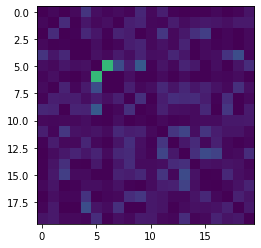

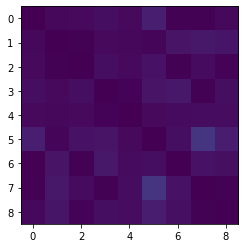

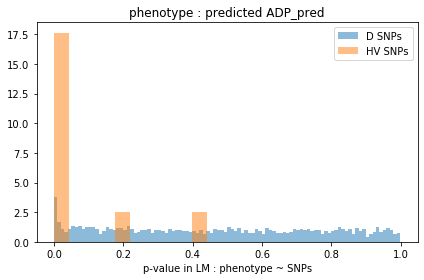

In [86]:
all_d_hits = [s for s in dgw.SNP.unique().tolist() if s in gen.columns]

for pheno in pheno_cols:
    lm = LinearRegression().fit(X_G_H[cov.columns],X_G_H[pheno])
    adj_cov = X_G_H[pheno] - lm.predict(X_G_H[cov.columns])
    
    plot_correlations(X_G_H,significant_SNPs[pheno])
    
    to_remove = []
    
    for i in range(len(significant_SNPs[pheno])):
        for j in range(i+1,len(significant_SNPs[pheno])):
            s1 = significant_SNPs[pheno][i]
            s2 = significant_SNPs[pheno][j]
            if s2 in to_remove: continue
            if s1 in to_remove: continue
            if pearsonr(X_G_H[s1],X_G_H[s2])[0]**2 > 1e-4:
                to_remove.append(s2)
    
    uncorr_significant_snps = [s for s in significant_SNPs[pheno] if s not in to_remove]
    
    plot_correlations(X_G_H,uncorr_significant_snps)
    
    all_hits = list(set(all_d_hits + uncorr_significant_snps))
    #all_hits = significant_SNPs[pheno]
    lm = LinearRegression().fit(X_G_H[all_hits],adj_cov)
    pred = lm.predict(X_G_H[all_hits])
    
    lm_info = get_lm_info(X_G_H[all_hits],adj_cov,pred,lm)
    lm_info["P_alone"] = [pearsonr(X_G_H[s],adj_cov)[1] for s in all_hits]
    lm_info["SNP"] = all_hits
    lm_info.set_index("SNP",inplace=True)
    
    plt.figure()
    plt.hist(lm_info["P"],density=True,bins=100,alpha=.5,label="D SNPs")
    plt.hist(lm_info.loc[uncorr_significant_snps,"P"],density=True,alpha=.5,label="HV SNPs")
    plt.xlabel("p-value in LM : phenotype ~ SNPs")
    plt.title("phenotype : predicted %s" % pheno)
    plt.legend()
    plt.tight_layout()

In [91]:
gw["pheno"] = "ADP_pred"

In [107]:
illustrate = pd.merge(gw.loc[gw.pheno == pheno],lm_info,left_on="ID",right_index=True,how="inner")\
    .rename(columns={"ID":"SNP","#CHROM":"CHR"})

In [110]:
illustrate

,SNP,CHR,POS,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,P_BOLT_LMM_INF,P_x,MBP,PHENO,pheno,Coefficients,Standard Errors,t values,P_y,P_alone
6101,rs141190925,1,2234040,0,CAGG,C,0.825542,0.005205,-0.011743,0.009354,0.21000,0.19000,2,ADP_pred,ADP_pred,0.0128,0.009,1.361,0.173624,0.213433
8932,rs113565775,1,2978755,0,A,AG,0.808527,0.032835,0.002072,0.009216,0.82000,0.76000,2,ADP_pred,ADP_pred,0.0007,0.009,0.070,0.943848,0.793577
8985,rs1569419,1,2996602,0,T,C,0.235053,0.040325,0.008260,0.008528,0.33000,0.37000,2,ADP_pred,ADP_pred,0.0064,0.009,0.734,0.462890,0.291382
9490,rs79366678,1,3098571,0,A,G,0.941613,0.065121,-0.002875,0.015626,0.85000,0.80000,3,ADP_pred,ADP_pred,-0.0029,0.016,-0.184,0.854029,0.924637
9501,rs950200,1,3099194,0,A,G,0.411268,0.150214,0.005407,0.007857,0.49000,0.62000,3,ADP_pred,ADP_pred,0.0039,0.008,0.488,0.625519,0.587773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9770234,rs75107793,22,50628937,0,G,A,0.929544,0.024669,0.046133,0.014012,0.00099,0.00078,50,ADP_pred,ADP_pred,-0.0464,0.015,-3.103,0.001915,0.001506
9770238,rs73187247,22,50629872,0,C,T,0.862243,0.007405,-0.010442,0.010266,0.31000,0.32000,50,ADP_pred,ADP_pred,0.1191,0.050,2.381,0.017295,0.367404
9770276,rs6712,22,50637922,0,G,C,0.859790,0.014810,-0.007108,0.010214,0.49000,0.50000,50,ADP_pred,ADP_pred,-0.1053,0.050,-2.113,0.034576,0.578415
9772485,rs13053850,22,51108509,0,G,A,0.560893,0.006305,-0.010067,0.007208,0.16000,0.15000,51,ADP_pred,ADP_pred,0.0080,0.014,0.586,0.558094,0.210434


In [108]:
corr_snps = []

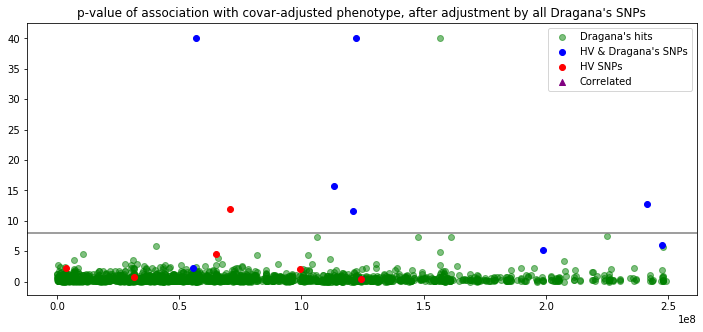

In [112]:
is_HV = illustrate.SNP.isin(significant_SNPs[pheno])
is_D = illustrate.SNP.isin(all_d_hits)
is_corr = illustrate.SNP.isin([significant_SNPs[pheno][i] for i in corr_snps])
plt.figure(figsize=(12,5))
plt.scatter(illustrate.loc[~is_HV,"POS"],-np.log10(illustrate.loc[~is_HV,"P_y"]),c="green",alpha=.5,label="Dragana's hits")
plt.scatter(illustrate.loc[is_HV & is_D,"POS"],-np.log10(illustrate.loc[is_HV & is_D,"P_y"]),c="blue",alpha=1,label="HV & Dragana's SNPs")
plt.scatter(illustrate.loc[is_HV & ~is_D,"POS"],-np.log10(illustrate.loc[is_HV & ~is_D,"P_y"]),c="red",alpha=1,label="HV SNPs")
plt.scatter(illustrate.loc[is_HV & is_corr,"POS"],-np.log10(illustrate.loc[is_HV & is_corr,"P_y"]),c="purple",marker="^",alpha=1,label="Correlated")
plt.axhline(8,c="grey")
plt.title("p-value of association with covar-adjusted phenotype, after adjustment by all Dragana's SNPs")
#plt.xticks([gw.loc[gw["#CHROM"] == i,"POS"].min() for i in range(1,23)],[str(i) for i in range(1,23)]);
plt.legend();

AttributeError: 'DataFrame' object has no attribute 'CHR'

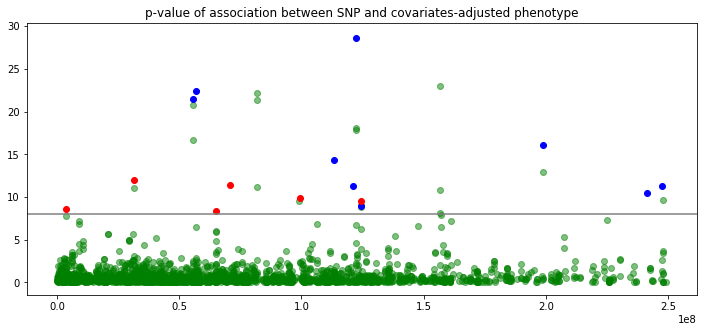

In [113]:
is_HV = illustrate.SNP.isin(significant_SNPs[pheno])
is_D = illustrate.SNP.isin(all_d_hits)
plt.figure(figsize=(12,5))
plt.scatter(illustrate.loc[~is_HV,"POS"],       np.clip(-np.log10(illustrate.loc[~is_HV,"P_alone"]),0,30),c="green",alpha=.5,label="Dragana's hits")
plt.scatter(illustrate.loc[is_HV & is_D,"POS"], np.clip(-np.log10(illustrate.loc[is_HV & is_D,"P_alone"]),0,30),c="blue",alpha=1,label="HV & Dragana's SNPs")
plt.scatter(illustrate.loc[is_HV & ~is_D,"POS"],np.clip(-np.log10(illustrate.loc[is_HV & ~is_D,"P_alone"]),0,30),c="red",alpha=1,label="HV SNPs")

plt.axhline(8,c="grey")
plt.title("p-value of association between SNP and covariates-adjusted phenotype")
for c in [gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)]:
    plt.axvline(c,color="grey",lw=1)
plt.xticks([gw.loc[gw.CHR == i,"POS"].min() for i in range(1,23)],[str(i) for i in range(1,23)]);
plt.legend();

# Look in Dragana's GWAS

In [33]:
dgw = pd.read_excel("/home/hv270/sysmex2pf/dragana_GWAS.xlsx")
dgw = dgw.rename(columns={"rsID (where available)":"SNP",'Gene Symbol(s) for Most Serious Consequence':"Gene"})
dgw = dgw.loc[dgw["SNP"].isin(all_significant_SNPs)]

/home/hv270/platelets/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  """Entry point for launching an IPython kernel.


In [34]:
sysmex_pheno = ~dgw.pivot_table(aggfunc="first",index="SNP",columns="Associated Blood Index",values=["Gene"])["Gene"].isnull()

In [35]:
genes = dgw.groupby("SNP")[["Gene"]].first()
genes

,Gene
SNP,
rs11916134,UMPS
rs1354034,ARHGEF3
rs415064,TUBB1
rs6993770,ZFPM2


In [36]:
sysmex_pheno["Dragana GWAS traits"] = ""
for c in sysmex_pheno.columns:
    if c == "Dragana GWAS traits": continue
    sysmex_pheno.loc[sysmex_pheno[c],"Dragana GWAS traits"] += "%s " % c

In [37]:
recap = pd.merge(recap,sysmex_pheno[["Dragana GWAS traits"]],how="left",left_index=True,right_index=True).fillna("")

In [38]:
import myvariant
mv = myvariant.MyVariantInfo()

gene_names = {}
to_query = recap.index.tolist()
a = mv.querymany(to_query,scopes='dbsnp.rsid', build="hg38",fetchall=False)

for i in range(len(a)):
    q = a[i]["query"]
    try:
        gene = a[i]["cadd"]["gene"]["genename"]
    except:
        try:
            gene = a[i]["dbsnp"]["gene"]["symbol"]
        except:
            try:
                gene = a[i]["wellderly"]["genename"]
            except:
                try:
                    gene = a[i]["snpeff"]["ann"]["genename"]
                except:
                    try:
                        gene = a[i]["snpeff"]["ann"][0]["genename"]
                    except:
                        if q == "rs111763415":
                            gene = "SUFU"
                        else:
                            gene = "not found"
    if q in gene_names:
        gene_names[q].append(gene)
    else:
        gene_names[q] = [gene]

for q in gene_names:
    recap.loc[q,"genes"] = ", ".join(list(set(gene_names[q])))

querying 1-13...done.
Finished.
7 input query terms found dup hits:
	[('rs2057150', 2), ('rs597808', 3), ('rs415064', 2), ('rs17020993', 2), ('rs9372251', 2), ('rs112516
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [39]:
# for gene ontology
for gene in recap.genes.unique().tolist():
    print(gene.split("-")[0])

ZFPM2
ATG9A
DDO
ARHGEF3
ATXN2
LOC101927379
SNX24
TUBB1
C4BPA
METTL24
LOC101927824
UMPS
PFKP


In [40]:
recap.sort_values(["CHR","BP"])

,causal_CCA,BETA_CCA,P_CCA,A1FREQ,CHR,BP,Dragana GWAS traits,genes
rs17020993,True,0.125358,4.300000e-19,0.879310,1,207288392,,C4BPA
rs72955435,True,0.098276,7.100000e-10,0.911575,2,220087354,,ATG9A
rs1354034,True,-0.058354,6.300000e-10,0.404338,3,56849749,HLSR# HLSR% LYMPH# LYMPH% MPV PCT PLT# RET# RET%,ARHGEF3
rs11916134,True,0.062459,1.300000e-09,0.730533,3,124453114,PCT,UMPS
rs6595407,True,-0.120646,6.400000e-40,0.443586,5,122100398,,LOC101927379-SNX2
rs425573,True,0.123047,4.400000e-37,0.670216,5,122326008,,SNX24
rs9372251,True,-0.061588,5.500000e-11,0.561868,6,110700656,,METTL24-DDO
rs2057150,True,-0.066250,2.300000e-09,0.732599,6,110716722,,DDO
rs6993770,True,0.120753,1.300000e-33,0.713156,8,106581528,MPV PCT PDW PLT#,ZFPM2
rs11251684,True,-0.070441,3.900000e-09,0.176845,10,3102379,,LOC101927824


In [35]:
recap.to_csv("/home/hv270/sysmex2pf/recap_%s.csv" % tag)

# Manhattan plot

In [33]:
gwas_results = pd.read_csv("/home/hv270/sysmex2pf/GWAS_table.csv",index_col=0)\
    .replace({"RP11-16L9.4":"PTPRC",
                  "OR2C3":"GCSAML",
                  "ANKMY1":"RNPEPL1",
                  "UMPS":"KALRN",
                  "PIF1":"PLEKHO2",
                  "TMEM120B":"RHOF"})

In [34]:
from matplotlib.colors import LinearSegmentedColormap

In [35]:
g = gw_.copy().sort_values("P")
g["MLOG10P"] = -np.log10(g.P)
g = g.sort_values("MLOG10P")
g["rank"] = np.arange(g.shape[0])
g["EMLOG10P"] = -np.log10(1-(g["rank"]/(g.shape[0]+1)))
g["sample_prob"] = np.power(10,g["EMLOG10P"]-2.5)

(array([994.,   4.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([3.16369880e-03, 8.32855693e-01, 1.66254769e+00, 2.49223968e+00,
        3.32193167e+00, 4.15162367e+00, 4.98131566e+00, 5.81100766e+00,
        6.64069965e+00, 7.47039165e+00, 8.30008364e+00]),
 <a list of 10 Patch objects>)

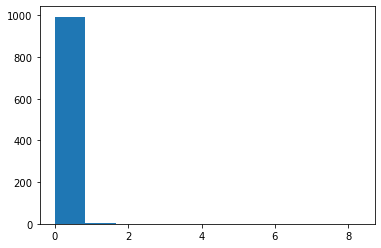

In [36]:
plt.hist(g.sample(1000)["sample_prob"])

In [37]:
g["showed"] = (np.random.uniform(0,1,g.shape[0]) < g["sample_prob"]) | (g.P < np.power(10,-2.5))
print(g.showed.mean())
#g = g.loc[g.showed & (g.P < 0.1)]

0.021760671363489376


In [42]:
shifts = {"PTPRC":(5e7,0),
         "GCSAML":(5e7,0),
         "SERPINE2":(-11.2e7,-3.2),
         "RNPEPL1":(1e7,0.5),
         "GRK5":(-4e7,0),
         "MRVI1":(9e7,0),
         "KALRN":(9e7,0),
         "HABP4":(-8e7,0),
         "P2RX1":(8e7,0),
         "PLEKHO2":(-1.1e8,-1.5)}

known_genes = ["MRVI1","GRK5","PEAR1","GP6","ARHGEF3","SVEP1"]

0.0021895891601704694
1.0


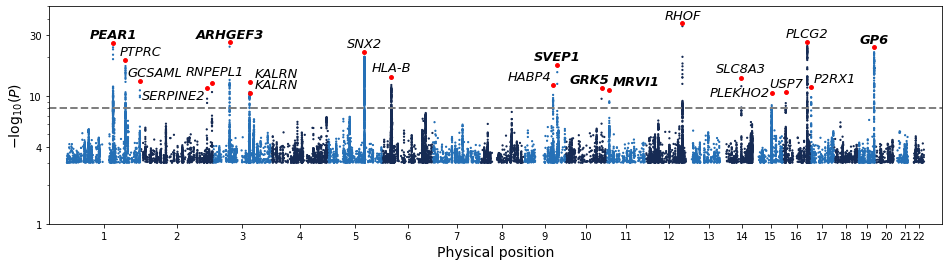

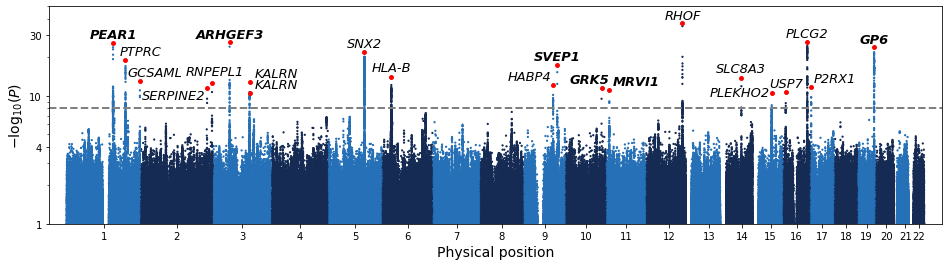

In [43]:
cmap = plt.get_cmap("Dark2")
bleu_1 = (22./256,43./256,84./256)
bleu_2 = (37./256,112./256,183./256)
cmap = LinearSegmentedColormap.from_list(name="ee",colors=[bleu_1,bleu_2])

for show_all in [False, True]:

    plt.figure(figsize=(16,4))

    #plt.axhline(10,c="grey",lw=2,alpha=.3)
    if show_all:
        cond = ~g.P.isnull()
    else:
        cond = g.P < 1e-3
    print(cond.mean())
    plt.scatter(g.loc[cond].G_POS,-np.log10(g.loc[cond].P),c=g.loc[cond,"#CHROM"] % 2,s=1.5,cmap=cmap)
    chrom_starts = [g.loc[g["#CHROM"] == ch,"G_POS"].min() for ch in range(1,23)]
    chrom_extremities = chrom_starts + [g.G_POS.max()]
    chrom_centers = (np.array(chrom_extremities[1:]) + np.array(chrom_extremities[:-1])) / 2
    plt.xticks(chrom_centers,[str(ch) for ch in range(1,23)])

    plt.axhline(-np.log10(1e-8),c="grey",ls="--",lw=2)

    #plt.axis("off")
    L = 6e7
    plt.xlim((-L,g.G_POS.max() + L))
    plt.yscale("log")
    plt.yticks([1,4,10,30],["1","4","10","30"])
    plt.ylim((1.,np.max(-np.log10(g.P))+15))
    plt.ylabel("$-\log_{10}(P)$",fontsize=14)

    for i, row in gwas_results.iterrows():
        cond = g.ID == row["SNP"]
        pos = g.loc[cond,"G_POS"] #+ (i % 2)*1e7 - 5e6
        height = 2 - np.log10(g.loc[cond,"P"])
        #color = "red" if row["SYMBOL"] in known_genes else "black"# "#FF8C00"
        weight = "bold" if row["SYMBOL"] in known_genes else None
        plt.scatter([pos],[height],s=15,c="red")
        shift_y = 0.
        shift_x = 0.
        if row["SYMBOL"] in shifts:
            shift_x, shift_y = shifts[row["SYMBOL"]]
        shift_y += 3*np.log10(height/5)
        plt.text(pos + shift_x, 
                 height+shift_y,
                 row["SYMBOL"],fontsize=13,weight=weight,style='italic',horizontalalignment='center')
    plt.xlabel("Physical position",fontsize=(14))
    #plt.tight_layout()
    if not show_all:
        plt.savefig("/home/hv270/sysmex2pf/figures/manhattan.pdf")
    else:
        plt.savefig("/home/hv270/sysmex2pf/figures/manhattan.png",dpi=300)